<a href="https://www.kaggle.com/code/kimonioannislappas/hotel-booking-predictive-models-kpi-dashboard?scriptVersionId=237433691" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Hotel Booking: From DataOps to Predictive Models & Business KPIs
## Part 1: Exploratory Machine Learning for Booking Cancellations & Stakeholders Reporting
## Part 2: KPI Business Dashboard in Looker Studio for Strategic Planning Monitoring

### All datasets and scripts are public — just click **"Copy & Edit"** to run this notebook yourself.

## **IMPORTANT INFORMATION BELOW**  
***************************************************************************************************************************************************
The initial project structure was developed in PyCharm, as it is a great option for building automation workflows. I also designed a full case study to simulate realistic challenges that hotel booking stakeholders (hotel owners, management teams, directors) might face.

This Kaggle notebook is just a version of the same project, which is originally hosted on GitHub in two separate subprojects. I provide the GitHub links to the initial project below.

I am especially happy with this Kaggle-adjusted version because it solves a key limitation I faced on GitHub: I couldn’t share my full working environment. The GitHub version is designed to connect to my local PostgreSQL database (to simulate a real-world setup), so the scripts can’t run out of the box on other machines. Here on Kaggle, though, I compromise real-world setup and just read the raw data into a pandas DataFrame (df) and hence, all you need to do is run this notebook!

***************************************************************************************************************************************************
Although the GitHub version isn't able to be easily shared, offers other advantages, particularly in terms of professionalism. The workflows are designed to closely simulate real-world scenarios and project structures. To explore the full project workflow, including Data and MLOps pipelines, as well as future upgrade suggestions, please refer to the documentation:    
**[DOCUMENTATION](https://drive.google.com/file/d/1xB5_aj08BEMVliJLg-h41F0X0rYDWYoN/view?usp=sharing)**  
***************************************************************************************************************************************************
Here are the GitHub links to the initial projects:  
[Part 1](https://github.com/kitlapp/BookingCancellationPrediction)  
[Part 2](https://github.com/kitlapp/LookerStudioKpiDashboard)

And here is the final Looker Studio KPI dashboard structure:  
[Looker Studio KPI Dashboard](https://lookerstudio.google.com/reporting/8ee13cf9-54e6-41ac-823e-af0706cec66c)
***************************************************************************************************************************************************
**OTHER NOTES ABOUT MY INITIAL PROJECT:**  
Note that I understand the weaknesses of my initial project, neither did I consider extreme cases or scalability when I had been developing it and this is the reason I include a future suggestions section in the provided documentation file. My solutions works though, at least at the level I assumed in my case study.

Additionally, I am completely self-taught in Data Science. Lacking jargon experience, I am questioning some Data Science senior operations terms. That is, I am happy with my DataOps but I already know that I could provide more MLOps and not only a log file for script execution monitoring. For this reason, I would prefer to use a more general language to describe what I did such as Data Science Operations – DSOps to be 100% to the point but I am afraid I will undersell my work if I would do that. Thus, I use the "correct" jargon terms but apriori state that especially project's MLOps has room for improvements.
***************************************************************************************************************************************************

## Assumptions
**1)** Both hotels have the same stakeholders (belong to the same group) who ask for answers about the high cancellation rates.  
**2)** Since I can't reach the stakeholders for more information, I am free to logically adapt to any potential challenges in order to properly interpret the results.    
***************************************************************************************************************************************************

## Part 1: Exploratory Machine Learning for Booking Cancellations & Stakeholders Reporting  

The goal is to predict the is_canceled feature following the owner's request to understand the reasons behind the high cancellation rates. Cancellations are a significant issue in the hospitality industry, as a room is reserved until the cancellation date, potentially resulting in lost revenue. If the cancellation occurs late, the room may not be rebooked in time. Furthermore, if the accommodation facility lacks a property management system (PMS), a high volume of cancellations can create additional complications and administrative overload. This increases operational costs by adding extra work for employees who do not contribute to the hotel's revenue-generating activities. Such inefficiencies are prone to errors, which could lead to double bookings or false reservations, further disrupting hotel operations and customer experience.

## 1. Import Libraries and Basics & Read Raw Data

In [1]:
# Copy the required script and data files to the working directory so they can be accessed by this notebook
import shutil
shutil.copy("/kaggle/input/secondary-scripts/cleaning.py", "/kaggle/working/"); 
shutil.copy("/kaggle/input/secondary-scripts/dictionaries.py", "/kaggle/working/");
shutil.copy("/kaggle/input/secondary-scripts/results.py", "/kaggle/working/");
shutil.copy("/kaggle/input/raw-data/hotel_booking.csv", "/kaggle/working/");

In [2]:
# Built-in libraries
import os
import time
import warnings

# Core data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant     

# Scikit-learn: preprocessing, model training, evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, balanced_accuracy_score, matthews_corrcoef,
)

# Custom modules
from cleaning import (
    explore_outliers, 
    month_components_calculation, 
    day_components_calculation
)
from dictionaries import country_to_category
from results import get_classification_metrics, logreg_interpretation, random_forest_interpretation

# Display and warning options
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_columns = 999

In [3]:
# Read raw dataset to a df
df_raw = pd.read_csv("hotel_booking.csv")

## 2. Preprocessing  
I handle the preprocessing steps of both projects at the same notebook (here). Note that the final cleaned data will be **logreg_rf_data.csv** and **dashboard_data.csv**. Since I need to follow different preprocessing steps depending on the objectives of each cleaned dataset, I note in the cells which preprocessing script is related to each cleaned dataset.

### 2.1. Handle NaNs

In [4]:
# Explore the NaNs:
df_raw.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
# Create two datafiles for preprocessing:
# One for ML tasks (df<number>) and a second one (dfdash<number>) for KPI dataframes creation
# 'dash' is from 'dashboard' because it will be used for KPI dataframes creation for looker studio dashboard

df2 = df_raw.copy()
dfdash = df_raw.copy()

# Fill missing values in 'children' column with the most frequent value (mode)
df2['children'] = df2['children'].fillna(value=df2['children'].mode()[0])

# Replace missing values in 'agent' with 0, indicating direct bookings without a travel agent
df2['agent'] = df2['agent'].fillna(value=0)

# Replace missing values in 'company' with 0, meaning bookings not linked to any company
df2['company'] = df2['company'].fillna(value=0)

# Drop all rows with missing 'country' values, since location info is important for analysis
df2 = df2.drop(labels=df2.loc[df2['country'].isna()].index)

##### DASHBOARD DATAFRAME PREPROCESSING #####
 # Fill missing values similarly for dashboard DataFrame
dfdash['children'] = dfdash['children'].fillna(value=dfdash['children'].mode()[0])
dfdash['agent'] = dfdash['agent'].fillna(value=0)
dfdash['company'] = dfdash['company'].fillna(value=0)
dfdash = dfdash.drop(labels=dfdash.loc[dfdash['country'].isna()].index)

### 2.2. Handle Date-Related Columns

In [6]:
# Make copies of the previous files
df3 = df2.copy()
dfdash2 = dfdash.copy()

# Create a dictionary to convert month names to their corresponding numeric values (as strings)
month_mapping = {
    "January": '1', "February": '2', "March": '3', "April": '4', "May": '5', "June": '6',
    "July": '7', "August": '8', "September": '9', "October": '10', "November": '11', "December": '12'
}

# Map month names in 'arrival_date_month' column to their numeric equivalents and convert them to integers
df3['arrival_date_month'] = df3['arrival_date_month'].map(month_mapping).astype(int)

##### DASHBOARD DATAFRAME PREPROCESSING #####
# I create a completed date column just in case I need to make Looker Studio interact with dates

# Map month names to integers using the same dictionary
dfdash2['arrival_date_month'] = dfdash2['arrival_date_month'].map(month_mapping).astype(int)

# Combine year, month, and day columns into a single date string in 'YYYY-MM-DD' format
dfdash2['arrival_date'] = (
    dfdash2['arrival_date_year'].astype(str) + '-' +
    dfdash2['arrival_date_month'].astype(str) + '-' +
    dfdash2['arrival_date_day_of_month'].astype(str)
)

# Convert the date strings into proper datetime objects for easier time-based analysis
dfdash2['arrival_date'] = pd.to_datetime(dfdash2['arrival_date'], format='%Y-%m-%d')

In [7]:
# As expected, the month of arrival is very strongly correlated with the week number of arrival.
# Let's confirm this by calculating their correlation:
df3['arrival_date_month'].corr(df3['arrival_date_week_number'])

0.9950937134411139

In [8]:
# Since they are highly correlated, we can safely drop 'arrival_date_week_number' to reduce redundancy.
df3 = df3.drop(columns='arrival_date_week_number')

Months and days of month have a cyclical nature which is not profound in the 1 to 12-month format and the corresponding 1 to 31-day format. The model will treat them as raw values where 12 is bigger than 1 and so on. To fix this, I created a custom function which calculates the cosine and sine components of months and days. The function can properly treat all possible number of days a month has, as well as February days even if it is a leap year.

In [9]:
# Apply custom functions to perform cyclic encoding on the 'arrival_date_month' and 'arrival_date_day_of_month' column.
# This helps machine learning models better understand the cyclical nature of months and days of months.
df4 = month_components_calculation(
    dataframe=df3, 
    month_columns=['arrival_date_month']
)
df5 = day_components_calculation(
    dataframe=df4, 
    year_columns=['arrival_date_year'], 
    month_columns=['arrival_date_month'], 
    day_columns=['arrival_date_day_of_month']
)

### 2.3. Check for Duplicates

In [10]:
# Count the number of fully duplicated rows in the preprocessed main dataframe
df5.duplicated().sum()

0

### 2.4. Drop some Columns: Data Leakage, High Cardinality, Data Anomalies & Strong Corellations  
I drop high cardinality columns which are unimportant for predicting cancellations. Additionally, columns associated with reservations must be dropped since they carry future information. For instance, if the reservation status date is earlier than the arrival date, the booking had already been canceled. The assigned room type was also dropped for the same reason.  

There are some data anomalies in the deposit type and car parking columns. Specifically, 99% of people who chose a non-refundable deposit type canceled. Additionally, 100% of people who required a parking space didn’t cancel. These are very strange, and since I can't reach the stakeholders for further clarification, they can’t be relied upon. For this reason, I dropped them from the dataset.  

Finally, the week number is highly correlated with the month of arrival, which makes sense. I decided to drop the week number and keep the month of arrival.

In [11]:
# Make copies of the previous files
df6 = df5.copy()
dfdash3 = dfdash2.copy()

# List of columns to be dropped as they are not needed for analysis
cols_to_be_dropped = ['name', 'email', 'arrival_date_month', 'arrival_date_day_of_month', 'phone-number', 'credit_card', 'reservation_status', 
                      'reservation_status_date', 'assigned_room_type','deposit_type', 'required_car_parking_spaces']

# Drop the columns specified in 'cols_to_be_dropped'
df6 = df6.drop(columns= cols_to_be_dropped)

# Display the shape of the dataframe after dropping columns
df6.shape

##### DASHBOARD DATAFRAME PREPROCESSING #####
# List of columns to be dropped from the dashboard dataframe
dashcols_to_be_dropped = ['name', 'email', 'arrival_date_month', 'arrival_date_day_of_month', 'phone-number', 'credit_card', 'reservation_status', 
                      'reservation_status_date', 'assigned_room_type','deposit_type', 'required_car_parking_spaces', 'arrival_date_week_number']

# Drop the unimportant columns from the dashboard dataframe
dfdash3 = dfdash3.drop(columns= dashcols_to_be_dropped)

### 2.5. Create total_kids Column

In [12]:
# Make copies of previous files
df7 = df6.copy()
dfdash4 = dfdash3.copy()

# Merge the 'children' and 'babies' columns to create a new column 'total_kids' representing the total number of kids
df7['total_kids'] = df7['children'].astype(int) + df7['babies'].astype(int)

# Drop the original 'children' and 'babies' columns after merging
df7 = df7.drop(columns=['children', 'babies'])

# Drop rows with outliers (total kids > 3) and reset index
df7 = df7.loc[df7['total_kids'] <= 3].reset_index(drop=True)

##### DASHBOARD DATAFRAME PREPROCESSING #####
# Merge the 'children' and 'babies' columns to create a new column 'total_kids' representing the total number of kids
dfdash4['total_kids'] = dfdash4['children'].astype(int) + dfdash4['babies'].astype(int)

# Drop the original 'children' and 'babies' columns after merging
dfdash4 = dfdash4.drop(columns=['children', 'babies'])

# Drop rows with outliers (total kids > 3) and reset index in the dashboard dataframe
dfdash4 = dfdash4.loc[dfdash4['total_kids'] <= 3].reset_index(drop=True)

### 2.6. Handle adults Column

In [13]:
# Make copies of previous files
df8 = df7.copy()
dfdash5 = dfdash4.copy()

# Exclude bookings where the number of adults is 0. Also, ensure that the number of adults is between 1 and 4.
df8 = df8[(df8['adults'] > 0) & (df8['adults'] <= 4)].reset_index(drop=True)

##### DASHBOARD DATAFRAME PREPROCESSING #####
# Exclude bookings where the number of adults is 0. Also, ensure that the number of adults is between 1 and 4.
dfdash5 = dfdash5[(dfdash5['adults'] > 0) & (dfdash5['adults'] <= 4)].reset_index(drop=True)

### 2.7. Handle meal Column

In [14]:
df9 = df8.copy()
dfdash6 = dfdash5.copy()

# Drop rows where the 'meal' column is 'Undefined', indicating no meal choice
df9 = df9.drop(labels=df9[df9['meal'] == 'Undefined'].index).reset_index(drop=True)

# Rename the 'meal' column to 'number_of_meals' for clarity
df9 = df9.rename(columns={'meal': 'number_of_meals'})

# Create a dictionary to map meal types to numerical values
meal_mapping = {'BB': 1, 'HB': 2, 'SC': 0, 'FB': 3}

# Map the dictionary to the 'number_of_meals' column, reducing complexity
df9['number_of_meals'] = df9['number_of_meals'].map(meal_mapping).astype(int)

# *** Ultimately, the 'meal' feature was reduced from 5 categories to 3 categories! ***

##### DASHBOARD DATAFRAME PREPROCESSING #####
# Drop rows where the 'meal' column is 'Undefined', indicating no meal choice
dfdash6 = dfdash6.drop(labels=dfdash6[dfdash6['meal'] == 'Undefined'].index).reset_index(drop=True)

# Rename the 'meal' column to 'number_of_meals' for clarity
dfdash6 = dfdash6.rename(columns={'meal': 'number_of_meals'})

# Map the dictionary to the 'number_of_meals' column, reducing complexity
dfdash6['number_of_meals'] = dfdash6['number_of_meals'].map(meal_mapping).astype(int)

### 2.8. Handle country Column

In [15]:
# Make copy of previous file
df10 = df9.copy()

# Map the 'country' column values to a smaller set of categories using the 'country_to_category' dictionary.
# This reduces 177 unique country values to only 15.
df10['country'] = df10['country'].map(country_to_category).astype('category')

# Drop the rows where the 'country' column is 'Antarctica', as it represents very few bookings and will reduce model complexity.
df10 = df10.drop(labels=df10[df10['country'] == 'Antarctica'].index, axis=0).reset_index(drop=True)

# Remove 'Antarctica' from the category list, as it has been dropped.
df10['country'] = df10['country'].cat.remove_categories('Antarctica')

# Drop any rows with NaN values to ensure clean data.
df10 = df10.dropna()

# *** Ultimately, the 'country' feature was reduced from 177 categories to only 15 categories! ***

### 2.9. Handle market_segment Column

In [16]:
# Make copies of previous files
df11 = df10.copy()
dfdash7 = dfdash6.copy()

# Drop all rows where the 'market_segment' column has the category 'Undefined', as it includes very few observations
df11 = df11.drop(labels=df11[df11['market_segment'] == 'Undefined'].index).reset_index(drop=True)

# Replace the 'Complementary' and 'Aviation' categories in the 'market_segment' column with 'Other' to consolidate rare categories
df11['market_segment'] = df11['market_segment'].replace({'Complementary': 'Other', 'Aviation': 'Other'}).astype('category')

# *** Ultimately, the 'market_segment' feature was reduced from 8 to 5 categories! ***

##### DASHBOARD DATAFRAME PREPROCESSING #####
# Drop all rows where the 'market_segment' column has the category 'Undefined'
dfdash7 = dfdash7.drop(labels=dfdash7[dfdash7['market_segment'] == 'Undefined'].index).reset_index(drop=True)

# Replace the 'Complementary' and 'Aviation' categories in the 'market_segment' column with 'Other'
dfdash7['market_segment'] = dfdash7['market_segment'].replace({'Complementary': 'Other', 'Aviation': 'Other'}).astype('category')

### 2.10. Handle distribution_channel Column

In [17]:
# Make copies of previous files
df12 = df11.copy()
dfdash8 = dfdash7.copy()

# Drop all rows where the 'distribution_channel' column has the category 'Undefined', as it includes very few observations
df12 = df12.drop(labels=df12[df12['distribution_channel'] == 'Undefined'].index).reset_index(drop=True)

# Convert the 'distribution_channel' column to categorical type
df12['distribution_channel'] = df12['distribution_channel'].astype('category')

# *** Ultimately, the 'distribution_channel' feature was reduced from 5 to 3 categories! ***

##### DASHBOARD DATAFRAME PREPROCESSING #####
# Drop all rows where the 'distribution_channel' column has the category 'Undefined'
dfdash8 = dfdash8.drop(labels=dfdash8[dfdash8['distribution_channel'] == 'Undefined'].index).reset_index(drop=True)

# Convert the 'distribution_channel' column to categorical type
dfdash8['distribution_channel'] = dfdash8['distribution_channel'].astype('category')

### 2.11. Handle reserved_room_type Column

In [18]:
# Make copies of previous files
df13 = df12.copy()
dfdash9 = dfdash8.copy()

# Merge categories in the 'reserved_room_type' column, combining multiple categories into 'Other'
df13['reserved_room_type'] = df13['reserved_room_type'].replace({'C': 'Other', 'B': 'Other', 'H': 'Other', 'L': 'Other'}).astype('category')

##### DASHBOARD DATAFRAME PREPROCESSING #####
# Merge categories in the 'reserved_room_type' column, combining multiple categories into 'Other'
dfdash9['reserved_room_type'] = dfdash9['reserved_room_type'].replace({'C': 'Other', 'B': 'Other', 'H': 'Other', 'L': 'Other'}).astype('category')

# *** Ultimately, the 'reserved_room_type' feature was reduced from 9 to 6 categories! ***

### 2.12. Handle agent & company Columns

In [19]:
# Make copies of previous files
df14 = df13.copy()
dfdash10 = dfdash9.copy()

# Convert 'agent' column to binary: 1 if not 0, else 0
df14['agent'] = df14['agent'].apply(lambda x: 1 if x != 0 else 0)

# Convert 'company' column to binary: 1 if not 0, else 0
df14['company'] = df14['company'].apply(lambda x: 1 if x != 0 else 0)

# Rename the columns to more intuitive names
df14 = df14.rename(columns={'agent': 'has_agent', 'company': 'has_company'})

##### DASHBOARD DATAFRAME PREPROCESSING #####
# Convert 'agent' column to binary: 1 if not 0, else 0
dfdash10['agent'] = dfdash10['agent'].apply(lambda x: 1 if x != 0 else 0)

# Convert 'company' column to binary: 1 if not 0, else 0
dfdash10['company'] = dfdash10['company'].apply(lambda x: 1 if x != 0 else 0)

# Rename the columns to more intuitive names
dfdash10 = dfdash10.rename(columns={'agent': 'has_agent', 'company': 'has_company'})

### 2.13. Handle Cancellation Columns

In [20]:
# Make a copy of previous file
df15 = df14.copy()

# Apply transformation to 'previous_cancellations' column:
# Set to 2 if greater than or equal to 2, 0 if less than 1, else leave as is
df15['previous_cancellations'] = df15['previous_cancellations'].apply(lambda x: 2 if x >= 2 else (0 if x < 1 else x))

# Apply transformation to 'previous_bookings_not_canceled' column:
# Set to 2 if greater than or equal to 2, 0 if less than 1, else leave as is
df15['previous_bookings_not_canceled'] = df15['previous_bookings_not_canceled'].apply(lambda x: 2 if x >= 2 else (0 if x < 1 else x))

# Rename the columns to more intuitive names
df15 = df15.rename(columns={'previous_cancellations': 'number_of_previous_cancellations', 
                            'previous_bookings_not_canceled': 'number_of_previous_bookings_not_canceled'})

### 2.14. Handle booking_changes & total_of_special_requests Columns

In [21]:
# Make a copy of previous file
df16 = df15.copy()

# Apply transformation to 'booking_changes' column:
# Set to 3 if greater than 2, 2 if equal to 2, 1 if equal to 1, else leave as is
df16['booking_changes'] = df16['booking_changes'].apply(lambda x: 3 if x > 2 else (2 if x == 2 else (1 if x == 1 else x)))

# Apply transformation to 'total_of_special_requests' column:
# Set to 3 if greater than 2, 2 if equal to 2, 1 if equal to 1, else leave as is
df16['total_of_special_requests'] = df16['total_of_special_requests'].apply(lambda x: 3 if x > 2 else (2 if x == 2 else (1 if x == 1 else x)))

# Rename the columns to more intuitive names
df16 = df16.rename(columns={'booking_changes': 'number_of_booking_changes', 'total_of_special_requests': 'number_of_special_requests'})

### 2.15. Handle days_in_waiting_list Column

In [22]:
# Make a copy of previous file
df17 = df16.copy()

# Apply transformation to 'days_in_waiting_list' column:
# Set to 1 if greater than 0, else leave as is
df17['days_in_waiting_list'] = df17['days_in_waiting_list'].apply(lambda x: 1 if x > 0 else x)

# Rename the 'days_in_waiting_list' column to 'has_waited'
df17 = df17.rename(columns={'days_in_waiting_list': 'has_waited'})

### 2.16. Handle Outliers

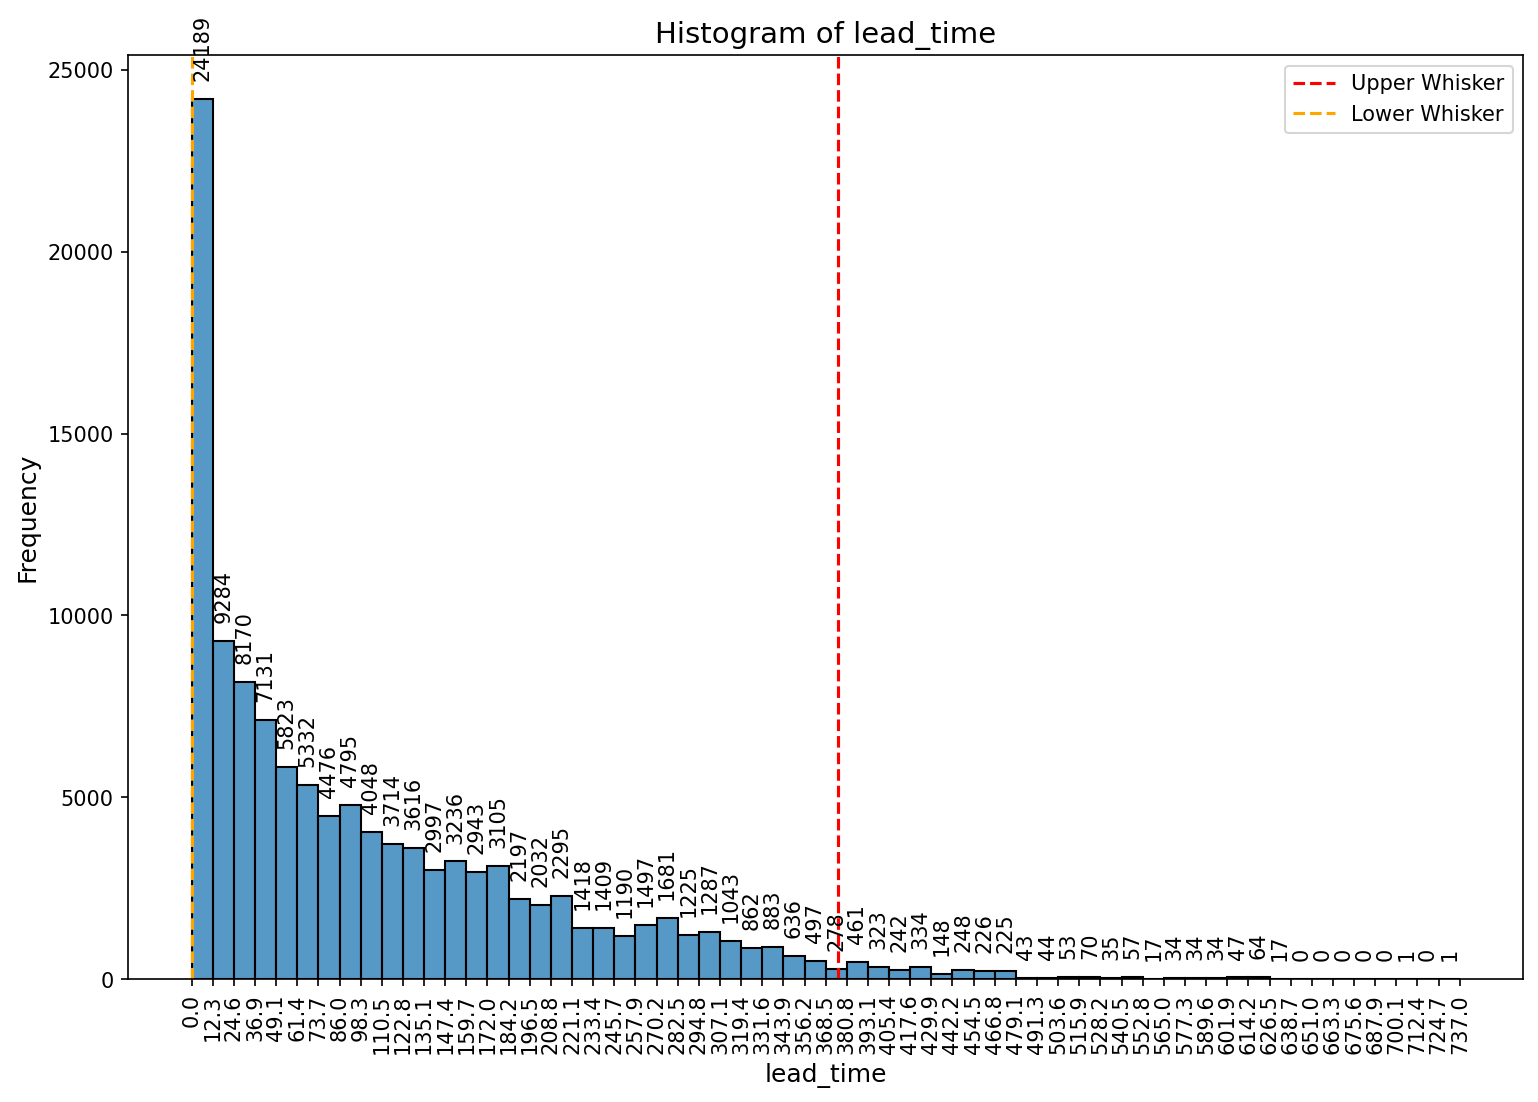

In [23]:
# Calling the explore_outliers function to visualize the distribution of some features
explore_outliers(dataframe=df17, column='lead_time', number_of_bins=60, negative=False);

In [24]:
# Make copies of previous files
df18 = df17.copy()
dfdash11 = dfdash10.copy()

# Set the threshold values for ADR (average daily rate) and lead_time outliers:
adr_outlier_value = 5400  # Maximum acceptable value for ADR
lead_time_outlier_border = 640  # Maximum acceptable value for lead time

# Remove rows where ADR is higher than the defined threshold or negative:
df18 = df18.loc[(df18['adr'] < adr_outlier_value) & (df18['adr'] >= 0)].reset_index(drop=True)

# Remove rows where lead_time exceeds the defined threshold:
df18 = df18.loc[df18['lead_time'] < lead_time_outlier_border].reset_index(drop=True)

##### DASHBOARD DATAFRAME PREPROCESSING #####
# Remove rows where ADR is higher than the defined threshold or negative in the dashboard dataframe:
dfdash11 = dfdash11.loc[(dfdash11['adr'] < adr_outlier_value) & (dfdash11['adr'] >= 0)].reset_index(drop=True)

# Remove rows where lead_time exceeds the defined threshold in the dashboard dataframe:
dfdash11 = dfdash11.loc[dfdash11['lead_time'] < lead_time_outlier_border].reset_index(drop=True)

### 2.17. Final Check on dtypes

In [25]:
# Make copies of previous files
df19 = df18.copy()
dfdash12 = dfdash11.copy()

# Specify columns to be converted to categorical data type:
cols_to_be_categorized = ['hotel', 'arrival_date_year', 'customer_type']

# Convert the specified columns to categorical data type:
df19[cols_to_be_categorized] = df19[cols_to_be_categorized].astype('category')

##### DASHBOARD DATAFRAME PREPROCESSING #####
# Specify columns in the dashboard dataframe to be converted to categorical data type:
dashcols_to_be_categorized = ['hotel', 'customer_type', 'country']

# Convert the specified columns in the dashboard dataframe to categorical data type:
dfdash12[dashcols_to_be_categorized] = dfdash12[dashcols_to_be_categorized].astype('category')

### 2.18. Encode Categories

In [26]:
# Specify the list of columns to be one-hot encoded:
categories = ['hotel', 'arrival_date_year', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'customer_type']

# Apply one-hot encoding on the selected columns in df19 and drop the first category to avoid multicollinearity:
df20 = pd.get_dummies(data=df19, columns=categories, drop_first=True)

# Identify columns with boolean data type:
boolean_cols = df20.columns[df20.dtypes == 'bool']

# Convert boolean columns to integers (True becomes 1, False becomes 0):
df20[boolean_cols] = df20[boolean_cols].astype(int)

## 3. Check for Multicolinearity (Optional)

In [27]:
X = df20.copy()

# Add a constant (intercept) column to the DataFrame X to use in regression models:
X_with_const = add_constant(X)

# Initialize an empty DataFrame to store the features and their corresponding VIF values:
vif = pd.DataFrame()

# Assign column names to the DataFrame: one for features and the other for VIF values:
vif["Feature"] = X_with_const.columns

# Calculate the Variance Inflation Factor (VIF) for each feature in the dataset
# and store the values in the "VIF" column of the DataFrame:
vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Sort the DataFrame 'vif' in descending order based on the VIF values to identify 
# the features with the highest multicollinearity (i.e., those with the highest VIF).
vif_sorted = vif.sort_values(by="VIF", ascending=False)
# Filter the sorted 'vif' DataFrame to display only the features with a VIF greater than 5
vif_sorted[vif_sorted['VIF'] > 5]

,Feature,VIF
0,const,238.009792
31,country_Portugal,27.048126
41,market_segment_Online TA,23.930149
40,market_segment_Offline TA/TO,15.137108
36,country_UK & Ireland,13.406237
38,market_segment_Direct,12.539236
39,market_segment_Groups,11.788532
43,distribution_channel_Direct,10.213691
45,distribution_channel_TA/TO,10.128723
26,country_France,9.581941


## 4. Export Cleaned Files

In [28]:
df20.to_csv("logreg_rf_data.csv", index=False)
dfdash12.to_csv("dashboard_data.csv", index=False)

## 5. Baseline Logistic Regression Model

The preprocessed file needed is the **logreg_rf_data.csv**.  
***************************************************************************************************************************************************

Logistic Regression runs smoothly without encountering any challenges. I decided not to use GridSearchCV because I don’t want to increase the runtime too much. I prefer to tune the hyperparameter values manually using trial-and-error techniques, reducing automation but conducting many trials in a short amount of time. The best logreg model occurres with the ‘newton-cg’ solver, which is efficient for large datasets with a lot of features.  

Additionally, I change class_weight to ‘balanced’ because my classes are slightly imbalanced and I don’t want to affect the dataset using either undersampling or oversampling techniques. Of course, I run the logreg model with random_state equal to 42 to compare its results with the Random Forest (from now on: ‘RF’) model.

In [29]:
# Read cleaned data for ML tasks
df = pd.read_csv("logreg_rf_data.csv")

### 5.1. Create Features & Target

In [30]:
# Create the DataFrame with features:
X = df.drop(columns=['is_canceled'], axis=1)
print('Shape of Features:', X.shape)
# Create the target series:
y = df['is_canceled']
print('Shape of Target:', y.shape)

Shape of Features: (116043, 52)
Shape of Target: (116043,)


### 5.2. Train Test Split

In [31]:
# Split features and target into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)
print('Percentage of Minority Class in Training:', y_train.value_counts().values[1] * 100 / len(y_train))
print('Percentage of Minority Class in Test:', y_test.value_counts().values[1] * 100 / len(y_test))

Shape of X_train: (92834, 52)
Shape of X_test: (23209, 52)
Shape of y_train: (92834,)
Shape of y_test: (23209,)
Percentage of Minority Class in Training: 37.483034233147336
Percentage of Minority Class in Test: 37.48114955405231


### 5.3. Scale Features

In [32]:
features_to_scale = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'number_of_meals', 'number_of_previous_cancellations', 
                     'number_of_previous_bookings_not_canceled', 'number_of_booking_changes', 'adr', 'number_of_special_requests', 'total_kids']

# Create the scaler instance:
scaler = StandardScaler()

# Scale the X_train set:
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

### 5.4. Train & Validate, Make Predictions and Display Evaluation Results

Validation Recall Scores: [0.76092767 0.76049659 0.77325632]


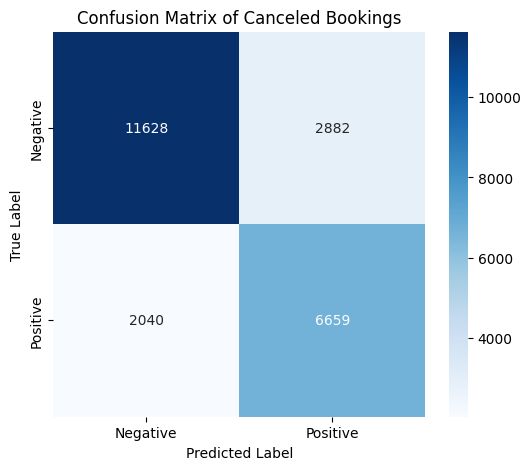

,Value
Metric,
Accuracy,0.7879
Balanced Accuracy,0.7834
Recall,0.7655
Precision,0.6979
F1 Score,0.7302
Φ Coefficient (MCC),0.5577
Runtime (Minutes),0.1900


In [33]:
# Start the timer
start_time = time.time()

model = LogisticRegression(penalty='l2', C=10, class_weight='balanced', random_state=42, solver='newton-cg', max_iter=100, n_jobs=-1)

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation using recall as the metric:
validation_scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=stratified_kfold, scoring='recall', n_jobs=-1)

# Print all 5 validation recall scores:
print(f"Validation Recall Scores: {validation_scores}")

# As long as validation scores are efficient, proceed with the model training:
model.fit(X_train, y_train)

# Apply the trained model on unseen data to test its performance:
y_pred = model.predict(X_test)

# Stop the timer
end_time = time.time()
# Calculate the time taken
elapsed_time_mins = round((end_time - start_time) / 60, 2)

# Call a custom function to display the model prediction scores:
df_eval = get_classification_metrics(y_test=y_test, y_pred=y_pred, conf_matrix_title='Confusion Matrix of Canceled Bookings', runtime=elapsed_time_mins)
df_eval

### 5.5. Results Interpretation

In [34]:
# Call a custom function to properly display the logistic regression results
interpretation_df = logreg_interpretation(X_train_scaled=X_train, model=model)
interpretation_df

,Feature,Odds Ratio,Normalized Odds - Proportionality to the Total Odds,Normalized Odds - Relation to the Maximum
50,customer_type_Transient,3.293270,0.066109,1.000000
39,market_segment_Online TA,2.550844,0.051206,0.774562
29,country_Portugal,2.505479,0.050295,0.760788
6,number_of_previous_cancellations,2.378002,0.047736,0.722079
37,market_segment_Groups,2.358754,0.047350,0.716235
0,lead_time,2.038455,0.040920,0.618976
21,arrival_date_year_2017,2.010160,0.040352,0.610384
20,arrival_date_year_2016,1.619126,0.032502,0.491647
12,adr,1.370404,0.027510,0.416123
14,x_comp_arrival_date_month,1.213571,0.024361,0.368500


## 6. Random Forest Model

Random Forest needs exactly the same dataset with logreg, that is, **logreg_rf_data.csv**.  
***************************************************************************************************************************************************
Features and targets as well as train, test splits and scaling must be exactly the same with the baseline logistic regression model. Therefore, I proceed directly with model training, validation, predictions and evaluation.  

Random Forest is an advanced traditional machine learning technique capable of both regression and classification tasks, making it a suitable choice for comparison against the baseline logistic regression model. The goal is to outperform the logreg model by generating better predictions for cancellations. 

Here it runs smoothly without encountering any challenges. I did not use GridSearchCV for the same reasons mentioned earlier, specifically, to avoid increasing the runtime unnecessarily. The best RF model was achieved with the criterion set to ‘entropy’, as it provided slightly better results compared to ‘gini’, while the runtimes were nearly identical.  

Additionally, I set max_features=None after noticing that this setting improved the results without leading to overfitting. 

### 6.1. Train & Validate, Make Predictions and Display Evaluation Results

Validation Recall Scores: [0.79765497 0.79575826 0.80377619]


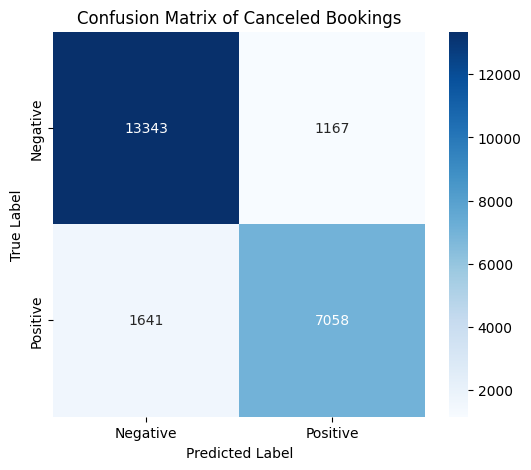

,Value
Metric,
Accuracy,0.8790
Balanced Accuracy,0.8655
Recall,0.8114
Precision,0.8581
F1 Score,0.8341
Φ Coefficient (MCC),0.7397
Runtime (Minutes),1.4800


In [35]:
# Start the timer
start_time = time.time()

model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=30, max_features=None, random_state=42, n_jobs=-1, class_weight='balanced')

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation using recall as the metric:
validation_scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=stratified_kfold, scoring='recall', n_jobs=-1)

# Print all 5 validation recall scores:
print(f"Validation Recall Scores: {validation_scores}")

# As long as validation scores are efficient, proceed with the model training:
model.fit(X_train, y_train)

# Apply the trained model on unseen data to test its performance:
y_pred = model.predict(X_test)

# Stop the timer
end_time = time.time()
# Calculate the time taken
elapsed_time_mins = round((end_time - start_time) / 60, 2)

# Call a custom function to display the model prediction scores:
df_eval = get_classification_metrics(y_test=y_test, y_pred=y_pred, conf_matrix_title='Confusion Matrix of Canceled Bookings', runtime=elapsed_time_mins)
df_eval

### 6.5. Results Interpretation

In [36]:
# Call a custom function to properly display the RF results
interpretation_df = random_forest_interpretation(X_train_scaled=X_train, model=model)
interpretation_df

,Feature,Importance
0,lead_time,0.203550
12,adr,0.102933
29,country_Portugal,0.090122
39,market_segment_Online TA,0.071919
13,number_of_special_requests,0.061716
17,y_comp_arrival_date_day_of_month,0.059246
16,x_comp_arrival_date_day_of_month,0.052529
2,stays_in_week_nights,0.033247
14,x_comp_arrival_date_month,0.026520
6,number_of_previous_cancellations,0.025898


## 7. Report to Stakeholders  
**What the Models Say about Cancellations?**  

• ADR AND LEAD TIME  
Both models showed that these are important features. I am satisfied with the Random Forest (RF) results, which highlight lead time and ADR as the most important features for predicting cancellations, as this makes logical sense. RF does not directly show feature direction or exact importance, but the fact that these variables contribute significantly to tree splits indicates a strong influence on predictions. We can also assume their relationship with cancellations is positive. First, this aligns with common sense, and second, it matches the corresponding positive odds in Logistic Regression (LogReg). In other words, a high ADR might cause a customer to cancel after finding a cheaper alternative, and a high lead time increases the likelihood of cancellation since plans often change over time.  

• NUMBER OF PREVIOUS CANCELLATIONS  
Both models showed that the number of previous cancellations is also important (5th highest odds ratio in LogReg and 10th most important feature in RF). This is expected, as people who canceled in the past are more likely to cancel again.  

• PEOPLE FROM PORTUGAL  
People from Portugal are more likely to cancel, but I cannot interpret this confidently without feedback from the stakeholders. However, I assume the hotels are located in Portugal, as most customers are Portuguese. In that case, there’s a possible explanation: natives may be moreflexible knowing the local areas and having more flexible dates, while international travelers usually have fixed travel plans, making them less likely to cancel.  

• ONLINE TRAVEL AGENCIES  
Both models showed a strong connection between OTA bookings and cancellations (2nd in LogReg odds and 4th in RF importance). We can also assume a positive direction here, based on both the models and logic. One explanation is that the online environment makes booking easier. Customers can book without paying upfront and compare many options at the same time. This might lead to spontaneous bookings, which are more likely to be canceled later.  
***************************************************************************************************************************************************
**Suggestions to the Stakeholders**  

• ADR & ONLINE TRAVEL AGENCIES  
Hotels should use Property Management Systems (PMS) with dynamic pricing, uploading realtime price updates to OTAs. Dynamic pricing must adapt to market conditions, seasonal trends and customer behavior. A good Machine Learning model can support this in real-time by learning from historical data and ongoing booking trends. It can identify patterns where cancellations are more likely and suggest price changes to reduce risk. Also, modern PMS systems aim to reduce OTA dependency by increasing direct bookings, which usually bring higher margins and lower cancellation rates.  

• LEAD TIME  
Hotels could apply motivation strategies like “book for the next month and get a discount or a gift” to encourage short-term bookings and reduce the risks of long lead times. For bookings made far in advance (e.g., more than one year), they could offer a small discount only if the booking is paid upfront. This way, both the hotel and the customer benefit from security and commitment.  

• NUMBER OF PREVIOUS CANCELLATIONS  
A solution here is to create personalized offers for users who canceled in the past. These could be combined with lead-time strategies, such as offering upfront-pay discounts for frequent cancelers, to reduce future risk.  

• PORTUGUESE PEOPLE  
There is a mutual benefit on supporting the domestic market with discounted direct booking options targeted at Portuguese customers, especially during low-demand seasons. This builds loyalty and may reduce the overall cancellation rate from locals.

## Part 2: KPI Business Dashboard in Looker Studio for Strategic Planning Monitoring

The preprocessed file needed is the **dashboard_data.csv**.  
***************************************************************************************************************************************************
I calculate KPIs based on both part 1 and hospitality domain knowledge. For example, I include financial KPIs in addition to KPIs related to booking cancellations, to provide a complete picture of strategic KPIs to the stakeholders. I store the KPIs in two tabular structures (**hotel_market_segments.csv** and **hotel_kpis.csv**) locally on my machine without loading them into the company's db. 

Since my case study is about a static but fully updated KPI dashboard, the calculated fields needed in LS can be prepared outside of it using Python. In this way, the dashboard update times are minimized because LS only needs to reconnect to the updated data sources after each new data upload. After this short task, the static but fully updated KPI dashboard is ready to be shared with stakeholders.  

Finally, the person who works with LS does not need to know low-level dashboard coding. They only need to follow simple, repeated steps in LS data management.

In [37]:
# Read the correct cleaned dataset for KPI creation
df = pd.read_csv("dashboard_data.csv")

## 8. Create the KPI DataFrames and Export them to .csv Files

In [38]:
filter_city_hotel = df[df['hotel'] == 'City Hotel']
filter_resort_hotel = df[df['hotel'] == 'Resort Hotel']

total_obs = df.shape[0]
total_obs_city_hotel = df[df['hotel'] == 'City Hotel'].shape[0]
total_obs_resort_hotel = df[df['hotel'] == 'Resort Hotel'].shape[0]

# AVERAGE CANCELLATION RATE
avg_canc_rate = round(df['is_canceled'].mean() * 100, 2)
avg_canc_rate_city_hotel = round(filter_city_hotel['is_canceled'].mean() * 100, 2)
avg_canc_rate_resort_hotel = round(filter_resort_hotel['is_canceled'].mean() * 100, 2)
print(f"Average Cancellation Rate: {avg_canc_rate} %")
print(f"Average Cancellation Rate City Hotel: {avg_canc_rate_city_hotel} %")
print(f"Average Cancellation Rate Resort Hotel: {avg_canc_rate_resort_hotel} %")

# AVERAGE PREVIOUS CANCELLATION RATE
avg_previous_canc_rate = round(df['previous_cancellations'].mean() * 100, 2)
avg_previous_canc_rate_city_hotel = round(filter_city_hotel['previous_cancellations'].mean() * 100, 2)
avg_previous_canc_rate_resort_hotel = round(filter_resort_hotel['previous_cancellations'].mean() * 100, 2)
print(f"Average Previous Cancellation Rate: {avg_previous_canc_rate} %")
print(f"Average Previous Cancellation Rate City Hotel: {avg_previous_canc_rate_city_hotel} %")
print(f"Average Previous Cancellation Rate Resort Hotel: {avg_previous_canc_rate_resort_hotel} %")


# TOTAL REVENUE
total_revenue = round(df['adr'].sum())
total_revenue_city_hotel = round(filter_city_hotel['adr'].sum())
total_revenue_resort_hotel = round(filter_resort_hotel['adr'].sum())
print(f"Total Revenue: {total_revenue} €")
print(f"Total Revenue City Hotel: {total_revenue_city_hotel} €")
print(f"Total Revenue Resort Hotel: {total_revenue_resort_hotel} €")

# AVERAGE DAILY RATE
adr = round(df['adr'].mean(), 2)
adr_city_hotel = round(filter_city_hotel['adr'].mean(), 2)
adr_resort_hotel = round(filter_resort_hotel['adr'].mean(), 2)
print(f"Average Daily Rate: {adr} €")
print(f"Average Daily Rate City Hotel: {adr_city_hotel} €")
print(f"Average Daily Rate Resort Hotel: {adr_resort_hotel} €")

# AVERAGE LEAD TIME
avg_lead_time = round(df['lead_time'].mean(), 2)
avg_lead_time_city_hotel = round(filter_city_hotel['lead_time'].mean(), 2)
avg_lead_time_resort_hotel = round(filter_resort_hotel['lead_time'].mean(), 2)
print(f"Average Lead Time: {avg_lead_time} days")
print(f"Average Lead Time City Hotel: {avg_lead_time_city_hotel} days")
print(f"Average Lead TIme Resort Hotel: {avg_lead_time_resort_hotel} days")

# REVENUE PER GUEST
total_guests = df['adults'].sum() + df['total_kids'].sum()
total_guests_city_hotel = filter_city_hotel['adults'].sum() + filter_city_hotel['total_kids'].sum()
total_guests_resort_hotel = filter_resort_hotel['adults'].sum() + filter_resort_hotel['total_kids'].sum()

revpg = round(total_revenue / total_guests, 2)
revpg_city_hotel = round(total_revenue_city_hotel / total_guests_city_hotel, 2)
revpg_resort_hotel = round(total_revenue_resort_hotel / total_guests_resort_hotel, 2)
print(f"Average Revenue per Guest: {revpg} €")
print(f"Average Revenue per Guest City Hotel: {revpg_city_hotel} €")
print(f"Average Revenue per Guest Resort Hotel: {revpg_resort_hotel} €")

# LENGTH OF STAY
total_nights = df['stays_in_week_nights'].sum() + df['stays_in_weekend_nights'].sum()
total_nights_city_hotel = filter_city_hotel['stays_in_week_nights'].sum() + filter_city_hotel['stays_in_weekend_nights'].sum()
total_nights_resort_hotel = filter_resort_hotel['stays_in_week_nights'].sum() + filter_resort_hotel['stays_in_weekend_nights'].sum()

length_of_stay = round(total_nights / total_obs, 2)
length_of_stay_city_hotel = round(total_nights_city_hotel / total_obs_city_hotel, 2)
length_of_stay_resort_hotel = round(total_nights_resort_hotel / total_obs_resort_hotel, 2)
print(f"Length of Stay: {length_of_stay} days")
print(f"Length of Stay City Hotel: {length_of_stay_city_hotel} days")
print(f"Length of Stay Resort Hotel: {length_of_stay_resort_hotel} days")

# BOOKINGS BY SOURCE (DATAFRAME)
values = df['market_segment'].value_counts().values
values_perc = np.round(100 * (values / total_obs), 2)
values_city_hotel = df[df['hotel'] == 'City Hotel']['market_segment'].value_counts().values
values_perc_city_hotel = np.round(100 * (values_city_hotel / total_obs_city_hotel), 2)
values_resort_hotel = df[df['hotel'] == 'Resort Hotel']['market_segment'].value_counts().values
values_perc_resort_hotel = np.round(100 * (values_resort_hotel / total_obs_resort_hotel), 2)

index = df['market_segment'].value_counts().keys()
columns = ['Total Counts', 'Total Counts (%)','City Hotel Counts', 'City Hotel Counts (%)', 'Resort Hotel Counts', 'Resort Hotel Counts (%)']
data = list(zip(values, values_perc, values_city_hotel, values_perc_city_hotel, values_resort_hotel, values_perc_resort_hotel))

market_df = pd.DataFrame(index=index, data=data, columns=columns)
market_df.index.name = 'Market Segment'
market_df

Average Cancellation Rate: 37.29 %
Average Cancellation Rate City Hotel: 41.79 %
Average Cancellation Rate Resort Hotel: 28.06 %
Average Previous Cancellation Rate: 8.76 %
Average Previous Cancellation Rate City Hotel: 8.0 %
Average Previous Cancellation Rate Resort Hotel: 10.31 %
Total Revenue: 11995007 €
Total Revenue City Hotel: 8327066 €
Total Revenue Resort Hotel: 3667942 €
Average Daily Rate: 102.25 €
Average Daily Rate City Hotel: 105.52 €
Average Daily Rate Resort Hotel: 95.52 €
Average Lead Time: 104.49 days
Average Lead Time City Hotel: 109.84 days
Average Lead TIme Resort Hotel: 93.5 days
Average Revenue per Guest: 51.88 €
Average Revenue per Guest City Hotel: 54.09 €
Average Revenue per Guest Resort Hotel: 47.49 €
Length of Stay: 3.42 days
Length of Stay City Hotel: 2.97 days
Length of Stay Resort Hotel: 4.34 days


,Total Counts,Total Counts (%),City Hotel Counts,City Hotel Counts (%),Resort Hotel Counts,Resort Hotel Counts (%)
Market Segment,,,,,,
Online TA,56129,47.84,38490,48.77,17639,45.94
Offline TA/TO,23857,20.34,16694,21.15,7163,18.65
Groups,18986,16.18,13958,17.69,6269,16.33
Direct,12310,10.49,6041,7.65,5028,13.09
Corporate,5083,4.33,2976,3.77,2107,5.49
Other,951,0.81,758,0.96,193,0.50


In [39]:
# KPIs Summary Table (One-row DataFrame)
kpis = {
    'Total Bookings': total_obs,
    'Total Bookings City Hotel': total_obs_city_hotel,
    'Total Bookings Resort Hotel': total_obs_resort_hotel,
    'Cancellation Rate (%)': avg_canc_rate,
    'Cancellation Rate City Hotel (%)': avg_canc_rate_city_hotel,
    'Cancellation Rate Resort Hotel (%)': avg_canc_rate_resort_hotel,
    'Previous Cancellation Rate (%)': avg_previous_canc_rate,
    'Previous Cancellation Rate City Hotel (%)': avg_previous_canc_rate_city_hotel,
    'Previous Cancellation Rate Resort Hotel (%)': avg_previous_canc_rate_resort_hotel,
    'Total Revenue (€)': total_revenue,
    'Total Revenue City Hotel (€)': total_revenue_city_hotel,
    'Total Revenue Resort Hotel (€)': total_revenue_resort_hotel,
    'ADR (€)': adr,
    'ADR City Hotel (€)': adr_city_hotel,
    'ADR Resort Hotel (€)': adr_resort_hotel,
    'Average Lead Time (days)': avg_lead_time,
    'Average Lead Time City Hotel (days)': avg_lead_time_city_hotel,
    'Average Lead Time Resort Hotel (days)': avg_lead_time_resort_hotel,
    'Revenue per Guest (€)': revpg,
    'Revenue per Guest City Hotel (€)': revpg_city_hotel,
    'Revenue per Guest Resort Hotel (€)': revpg_resort_hotel,
    'Length of Stay (days)': length_of_stay,
    'Length of Stay City Hotel (days)': length_of_stay_city_hotel,
    'Length of Stay Resort Hotel (days)': length_of_stay_resort_hotel
}

# Convert dict to a dataframe
kpis_df = pd.DataFrame([kpis])

# Save to CSV
kpis_df.to_csv('hotel_kpis.csv', index=False)
market_df.to_csv('hotel_market_segments.csv')

## 9. Display the Looker Studio Dashboard

Please follow the URL below which leads to the final KPI dashboard:  
[Looker Studio KPI Dashboard](https://lookerstudio.google.com/reporting/8ee13cf9-54e6-41ac-823e-af0706cec66c)  